In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from PIL import Image
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

[]


In [2]:
from keras.layers import Dense,Input,Activation,BatchNormalization,Reshape,Flatten
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import SGD
from keras.datasets import mnist

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def generator_model():
    #The first dense layer takes a vector of 100 dimensions as input and 
    #it produces 1,024 dimensions with the activation function tanh as the output
    model_in = Input((100,))
    model = Dense(1024,activation='tanh')(model_in)
    
    #The next dense layer produces data of 128 x 7 x 7 
    #in the output using batch normalization 
    model = Dense(128*7*7)(model)
    model = BatchNormalization()(model)
    model = Activation('tanh')(model)
    
    #produces data of  7 x 7 x 128 (128 channels, 7 width, and 7 height)
    model = Reshape((7,7,128))(model)
    #produces a repetition of each one into a 2 x 2 square
    model = UpSampling2D(size=(2,2))(model)
    model = Conv2D(64,kernel_size=(5,5),activation='tanh',padding='same')(model)
    
    model = UpSampling2D(size=(2,2))(model)
    model = Conv2D(1,kernel_size=(5,5),activation='tanh',padding='same')(model)
    
    model = Model(inputs=model_in,outputs=model)
    
    return model

In [4]:
def discriminator_model(): #鉴别模型
    #  MNIST image with the shape (28, 28, 1)
    model_in = Input((28,28,1))
    
    # 64 filters of size 5 x 5 with tanh as the activation function
    model = Conv2D(64,kernel_size=(5,5),padding='same',activation='tanh')(model_in)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Conv2D(128,kernel_size=(5,5),activation='tanh')(model)
    model = MaxPooling2D(pool_size=(2,2))(model)
    model = Flatten()(model)
    model = Dense(1024,activation='tanh')(model)
    model = Dense(1,activation='sigmoid')(model)
    
    model = Model(inputs=model_in,outputs=model)
    
    return model

In [5]:
def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [6]:
def train(BATCH_SIZE = 128):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    
    d = discriminator_model()
    g = generator_model()
    
    d_on_g = generator_containing_discriminator(g, d)
    
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    
    for epoch in range(100):
#         print('Epoch is', epoch)
#         print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save(str(epoch)+"_"+str(index)+".png")
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = d.train_on_batch(X, y)
#             print("batch %d d_loss : %f" % (index, d_loss))
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
#             print("batch %d g_loss : %f" % (index, g_loss))
            if index % 10 == 9:
                g.save_weights('generator', True)
                d.save_weights('discriminator', True)

In [7]:
train()

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
def generate(BATCH_SIZE=128, nice=False):
    g = generator_model()
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g.load_weights('generator')
    if nice:
        d = discriminator_model()
        d.compile(loss='binary_crossentropy', optimizer="SGD")
        d.load_weights('discriminator')
        noise = np.random.uniform(-1, 1, (BATCH_SIZE*20, 100))
        generated_images = g.predict(noise, verbose=1)
        d_pret = d.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE,) + generated_images.shape[1:3], dtype=np.float32)
        nice_images = nice_images[:, :, :, None]
        for i in range(BATCH_SIZE):
            idx = int(pre_with_index[i][1])
            nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]
        image = combine_images(nice_images)
    else:
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        generated_images = g.predict(noise, verbose=1)
        image = combine_images(generated_images)
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save("generated_image.png")

In [9]:
generate(nice=True)

2560/2560 [==============================] - 0s 116us/step


In [10]:
!ls

0_0.png     28_100.png	46_120.png  64_140.png	82_160.png
0_100.png   28_120.png	46_140.png  64_160.png	82_180.png
0_120.png   28_140.png	46_160.png  64_180.png	82_20.png
0_140.png   28_160.png	46_180.png  64_20.png	82_200.png
0_160.png   28_180.png	46_20.png   64_200.png	82_220.png
0_180.png   28_20.png	46_200.png  64_220.png	82_240.png
0_20.png    28_200.png	46_220.png  64_240.png	82_260.png
0_200.png   28_220.png	46_240.png  64_260.png	82_280.png
0_220.png   28_240.png	46_260.png  64_280.png	82_300.png
0_240.png   28_260.png	46_280.png  64_300.png	82_320.png
0_260.png   28_280.png	46_300.png  64_320.png	82_340.png
0_280.png   28_300.png	46_320.png  64_340.png	82_360.png
0_300.png   28_320.png	46_340.png  64_360.png	82_380.png
0_320.png   28_340.png	46_360.png  64_380.png	82_40.png
0_340.png   28_360.png	46_380.png  64_40.png	82_400.png
0_360.png   28_380.png	46_40.png   64_400.png	82_420.png
0_380.png   28_40.png	46_400.png  64_420.png	82_440.png
0_40.png    28_400.png	46_420.png  64

In [11]:
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


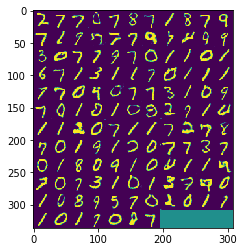

In [12]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('generated_image.png')
imgplot = plt.imshow(img)
plt.show()